In [ ]:
#link to dataset
#https://archive.ics.uci.edu/dataset/45/heart+disease
#!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

heart_disease = fetch_ucirepo(id=45)


X = heart_disease.data.features
y = heart_disease.data.targets

df = pd.concat([X, y], axis=1)

df.head()



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [ ]:
from sklearn.model_selection import train_test_split

df = df.dropna()
df['target'] = (df['num'] > 0).astype(int)
df = df.drop(columns=['num'])

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2026)

#used dummy variables for categorical columns
categorical_cols = ['cp', 'restecg', 'slope', 'thal']
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True, dtype=int)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

#scaled the numeric columns to make sure each columns had equal weights
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)



pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

df.loc[X_train.index, 'pred_target'] = pred_train
df.loc[X_test.index, 'pred_target'] = pred_test

#calculating base rate (assumed everyone has heart disease)
base_rate = (y_test == 1).mean()

#calculating prediction rate (based on logistic regression result)
prediction_rate = (y_test == pred_test).mean()

print(f"Base Rate: {base_rate:.2%}")
print(f"Model Accuracy: {prediction_rate:.2%}")






Base Rate: 53.33%
Model Accuracy: 83.33%


Text(0.5, 1.0, 'Logistic Regression Coefficients')

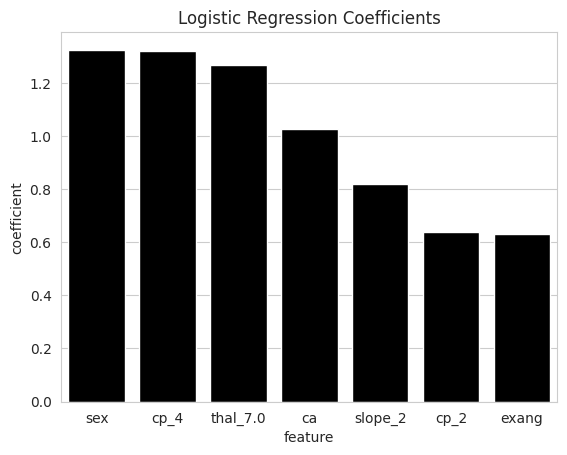

In [ ]:
#analyzing coefficient in the logistic regression
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)



ax = sns.barplot(coef_df.head(7), x = 'feature', y = 'coefficient', color = 'black')

ax.set_title("Logistic Regression Coefficients")
#age 1 is male, 0 is female


In [ ]:
#calculated fpr and fnr by sex
fpr_by_sex = df[df['target'] == 0].groupby("sex")["pred_target"].mean()

fnr_by_sex = 1 - df[df['target'] == 1].groupby("sex")["pred_target"].mean()

print("False positive rates")
print(fpr_by_sex)

print("\nFalse negative rates")
print(fnr_by_sex)


#women FNR is higher

False positive rates
sex
0    0.014085
1    0.134831
Name: pred_target, dtype: float64

False negative rates
sex
0    0.280000
1    0.169643
Name: pred_target, dtype: float64


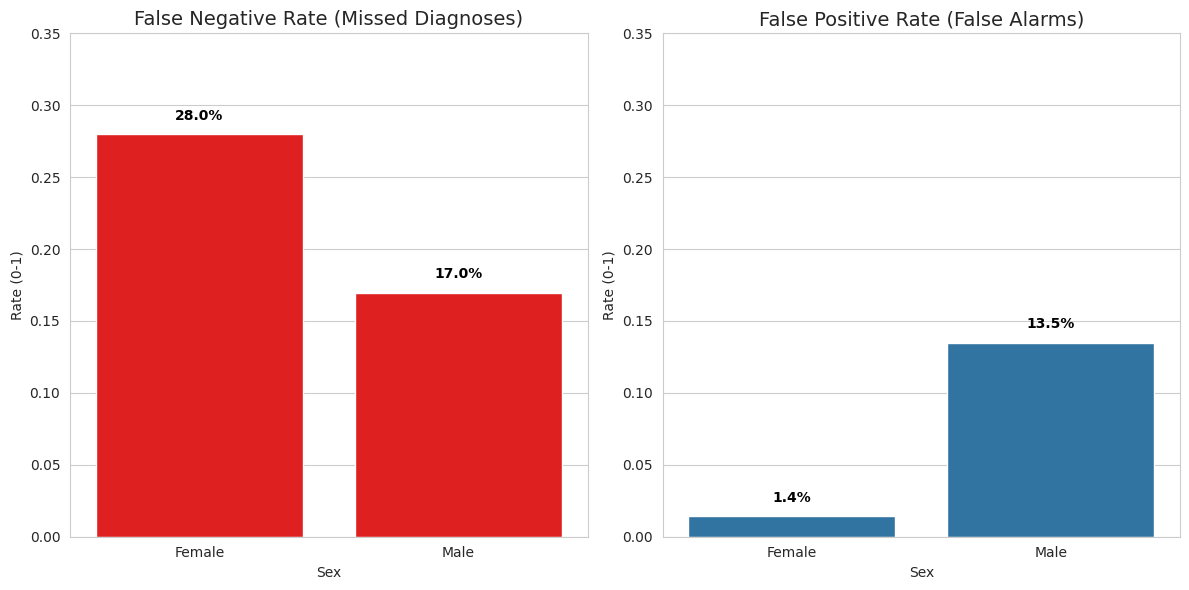

In [ ]:


plot_data = pd.DataFrame({
    'Sex': ['Female', 'Male'],
    'FNR': [fnr_by_sex[0], fnr_by_sex[1]],
    'FPR': [fpr_by_sex[0], fpr_by_sex[1]]
})

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


sns.barplot(data=plot_data, x='Sex', y='FNR', ax=axes[0], color = 'red')
axes[0].set_title('False Negative Rate (Missed Diagnoses)', fontsize=14)
axes[0].set_ylabel('Rate (0-1)')
axes[0].set_ylim(0, 0.35)

#plots the labels on the bar
for i, row in plot_data.iterrows():
    axes[0].text(i, row['FNR'] + 0.01, f"{row['FNR']:.1%}", ha='center', color='black', weight='bold')

sns.barplot(data=plot_data, x='Sex', y='FPR', ax=axes[1])
axes[1].set_title('False Positive Rate (False Alarms)', fontsize=14)
axes[1].set_ylabel('Rate (0-1)')
axes[1].set_ylim(0, 0.35)

#plots the labels on the bar
for i, row in plot_data.iterrows():
    axes[1].text(i, row['FPR'] + 0.01, f"{row['FPR']:.1%}", ha='center', color='black', weight='bold')

plt.tight_layout()
plt.show()

Area Under Curve (AUC): 0.9118


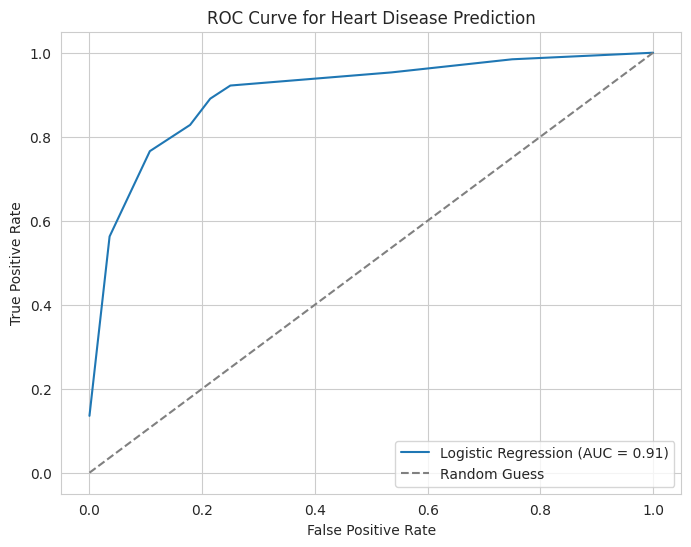

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get Probability Predictions
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate ROC Metrics
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
print(f"Area Under Curve (AUC): {auc_score:.4f}")

roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
})

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.lineplot(data=roc_df, x='False Positive Rate', y='True Positive Rate', label=f'Logistic Regression (AUC = {auc_score:.2f})', errorbar= None)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title('ROC Curve for Heart Disease Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

 BEST THRESHOLD for Women: 0.17
   New FNR: 10.0% (Matches Men)
   New FPR: 7.7% (False Alarms)


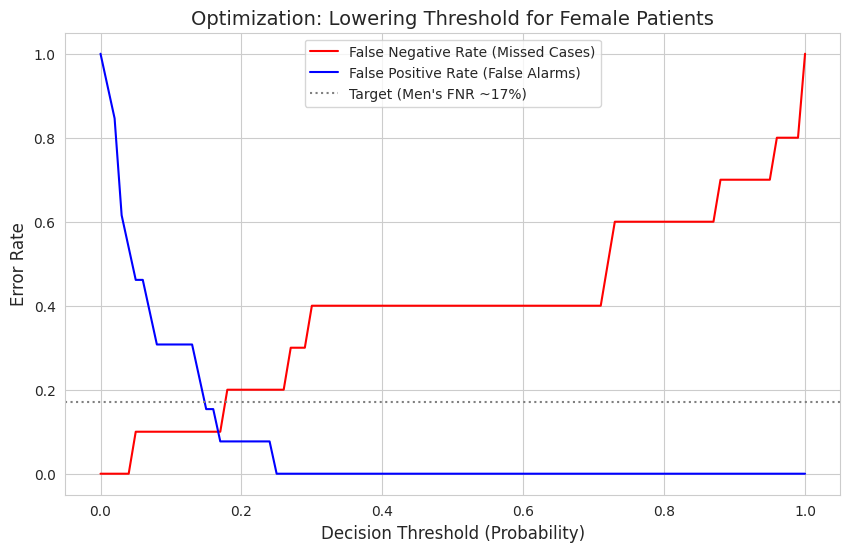

In [ ]:
from sklearn.metrics import confusion_matrix


y_probs = model.predict_proba(X_test)[:, 1]
test_data = X_test.copy()
test_data['y_true'] = y_test
test_data['prob_disease'] = y_probs

women_df = test_data[test_data['sex'] == 0]

thresholds = np.linspace(0, 1, 101)
results = []

#calculated the fnr and fpr of women based on threshold from 0 to 1 

for t in thresholds:
    preds = (women_df['prob_disease'] > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(women_df['y_true'], preds, labels=[0, 1]).ravel()

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (tn + fp) if (tn + fp) > 0 else 0

    results.append({'Threshold': t, 'FNR': fnr, 'FPR': fpr})

df_results = pd.DataFrame(results)


#chose 0.170 because that is the male FNR
#found the result that minimizes the FNR while having a reasonable FPR, so we found the end of that result. 
candidate = df_results[df_results['FNR'] <= 0.170].tail(1)


best_t = candidate.iloc[0]['Threshold']
best_fnr = candidate.iloc[0]['FNR']
best_fpr = candidate.iloc[0]['FPR']
print(f" BEST THRESHOLD for Women: {best_t:.2f}")
print(f"   New FNR: {best_fnr:.1%} (Matches Men)")
print(f"   New FPR: {best_fpr:.1%} (False Alarms)")


#Plot the Graph
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.lineplot(data=df_results, x='Threshold', y='FNR', label='False Negative Rate (Missed Cases)', color='red')

sns.lineplot(data=df_results, x='Threshold', y='FPR', label='False Positive Rate (False Alarms)', color='blue')


plt.title('Optimization: Lowering Threshold for Female Patients', fontsize=14)
plt.xlabel('Decision Threshold (Probability)', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.axhline(y=0.17, color='grey', linestyle=':', label="Target (Men's FNR ~17%)")
plt.legend()
plt.show()